In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE
import seaborn as sns
from genetic_algorithms import SimpleGeneticAlgorithm as GA
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
df = pd.read_csv('train.csv')
num_df = df._get_numeric_data().copy().fillna(0)

In [ ]:
target = 'Survived'
total_possible_vars = np.array(list(set(num_df.columns)-set([target])))

In [ ]:
X = num_df[total_possible_vars]
y = num_df[target]

In [ ]:
tree = DecisionTreeClassifier(random_state=42, max_depth=3)

In [ ]:
class GeneticAlgorithmFeatureSelection:
    
    def __init__(self, df, target, clf, n_iter=10, max_features=None, pop_step_size=4,
                 selective_pressure=1.5, sel_frac_per_step=0.5, n_selected_elite=1,
                 mutation_rate=None, seed=42, score='roc_auc', early_stopping=True,
                 early_stopping_rounds=20):

        np.random.seed(seed)
        if max_features is None:
            self.max_features = int(len(df.columns)*0.8)
        else:
            self.max_features = max_features
        self.pop_step_size = pop_step_size
        self.target = target
        self.total_vars = np.array(list(set(df.columns)-set([target])))
        self.X = df[self.total_vars]
        self.y = df[self.target]
        self.current_pop = self.initialization()
        self.score = score
        self.classifier = clf
        self.selective_pressure = selective_pressure
        self.n_sel_elite = n_selected_elite
        self.n_roulette = int(pop_step_size*sel_frac_per_step - n_selected_elite)
        self.sel_pop_hist = {}
        self.generation = 0
        if mutation_rate is None:
            self.mutation_rate = 1/self.total_vars.shape[0]
        else:
            self.mutation_rate = mutation_rate
        self.n_iter = n_iter
        self.selected_pop = None
        self.current_fitness_vector = None
        self.performance_evolution = list()
        self.best_score = None
        self._early_stopping_rounds = early_stopping_rounds
        self._rounds_with_no_improvement = 0
        
    def _check_if_valid_(self, pop):
        return np.where((pop.sum(axis=1)==0) |                      #must have at least one feature
                 (pop.sum(axis=1)>self.max_features))[0].size == 0  #must have less than max_features  
        
    def initialization(self):
        pop = np.random.randint(0, 2, size = (self.pop_step_size, self.total_vars.shape[0]))
        while not self._check_if_valid_(pop):
            pop = np.random.randint(0, 2, size = (self.pop_step_size, self.total_vars.shape[0]))
        return np.random.randint(0, 2, size = (self.pop_step_size, self.total_vars.shape[0]))
        
    def get_performance(self, encoded_var_list):
        variables = self.total_vars[np.where(encoded_var_list==1)]
        cross = cross_val_score(self.classifier, self.X[variables], self.y, cv=3, scoring = self.score)
        return cross.mean()
    
    def fitness_assignment(self):
        pop_performance = np.apply_along_axis(self.get_performance, axis=1, arr=self.current_pop)
        self.performance_evolution += [pop_performance.max()]
        if self.best_score is None:
            self.best_score = self.performance_evolution[-1]
        elif self.best_score < self.performance_evolution[-1]:
            self.best_score = self.performance_evolution[-1]
            self._rounds_with_no_improvement = 0
        else:
            self._rounds_with_no_improvement += 1
        rank = pop_performance.argsort().argsort()
        fitness = rank * self.selective_pressure
        self.current_fitness_vector = fitness
        self.selected_features = None
    
    def selection(self):
        f_rank = self.current_fitness_vector
        sel_by_elitism = self.current_pop[f_rank.argsort()[-self.n_sel_elite:]].reshape(self.n_sel_elite,-1)
        ind_of_remaining = f_rank.argsort()[:-self.n_sel_elite]
        prob_of_sel = f_rank[ind_of_remaining]/f_rank[ind_of_remaining].sum()
        sel_roulette = self.current_pop[np.random.choice(ind_of_remaining,
                                                         size=[self.n_roulette],
                                                         replace=False,
                                                         p=prob_of_sel)].reshape(self.n_roulette,-1)
        sel_pop = np.concatenate([sel_by_elitism,sel_roulette])
        self.sel_pop_hist[self.generation] = sel_pop
    
    def _cross_individuals_(self, pair):
        #choose alleles from each of the mating individuals at random
        #will implement one-point crossover in the future
        cross_result = np.random.binomial(1, 0.5, size = self.total_vars.shape[0]).reshape(1,-1) 
        mask = np.concatenate([cross_result*(-1)+1, cross_result])
        return (pair.reshape(2,-1)*mask).sum(axis=0) #result is of crossover between individuals
    
    def crossover(self):
        sel_pop = self.sel_pop_hist[self.generation]
        
        def gen_cross_pop():
            cross_pop = np.empty((self.pop_step_size, self.total_vars.shape[0]))
            for i in range(self.pop_step_size):
                sel_for_crossover = sel_pop[np.random.choice(np.arange(sel_pop.shape[0]), size=2, replace=False)]
                cross_pop[i] = self._cross_individuals_(sel_for_crossover)
            return cross_pop.astype(np.int)
        
        cross_pop = gen_cross_pop()
        while not self._check_if_valid_(cross_pop):
            cross_pop = gen_cross_pop()
        
        self.current_pop = cross_pop
    
    def mutation(self):
        # Get population generated by crossover
        cross_pop = self.current_pop
        
        def gen_mutated_pop():
            # Transform the matrix temporarily 1->1 and 0->-1
            transf_cross_pop = 2*cross_pop - 1
            mask = 2*np.random.binomial(1, self.mutation_rate, size=cross_pop.shape) - 1
            # Generate mutated population
            mutated_pop = (transf_cross_pop*mask+1)/2
            return mutated_pop.astype(np.int)
        
        mutated_pop = gen_mutated_pop()
        while not self._check_if_valid_(mutated_pop):
            mutated_pop = gen_mutated_pop()
        
        self.current_pop = mutated_pop
    
    def plot_evolution(self):
        _ = plt.figure(figsize=(12,6))
        _ = plt.plot(range(self.generation + 1),self.performance_evolution)
        plt.ylabel(self.score)
        plt.xlabel('Generation')
        plt.show()
    
    def run(self):
        flag_early_stopping = False
        while(self.generation<self.n_iter):
            self.fitness_assignment()
            self.selection()
            if self._rounds_with_no_improvement == self._early_stopping_rounds:
                flag_early_stopping = True
                break
            self.crossover()
            self.mutation()
            self.generation += 1
        if not flag_early_stopping:
            self.fitness_assignment()
            self.selection()
        encoded_var_list = self.sel_pop_hist[np.argmax(self.performance_evolution)][0]
        self.selected_features = self.total_vars[np.where(encoded_var_list==1)]

In [ ]:
rf = RandomForestClassifier(random_state=42, max_depth=4, min_samples_leaf=5, n_jobs=1)

In [ ]:
ga = GeneticAlgorithmFeatureSelection(num_df, target, rf, max_features=4, n_iter=120, n_selected_elite=1, seed=4)
ga.run()

In [ ]:
ga.plot_evolution()

In [ ]:
ga.selected_features

In [ ]:
cross_val_score(tree, num_df[ga.selected_features], num_df[target], scoring='roc_auc').mean()

In [ ]:
cross_val_score(tree, num_df[total_possible_vars], num_df[target], scoring='roc_auc').mean()

# House Price Dataset

In [3]:
df = pd.read_csv('house.csv')
num_df = df._get_numeric_data().copy().fillna(0)

In [4]:
target = 'SalePrice'
total_possible_vars = np.array(list(set(num_df.columns)-set([target])))

In [5]:
X = num_df[total_possible_vars]
y = num_df[target]

In [6]:
rf = RandomForestRegressor(random_state=42, max_depth=10, min_samples_leaf=5, n_jobs=1)

In [7]:
ga = GA(rf, score='neg_mean_squared_error', max_features=25, n_iter=120, n_selected_elite=1, seed=4)
ga.fit(X,y)

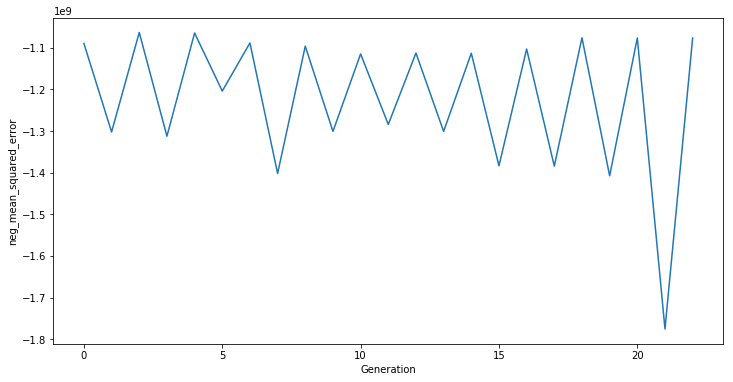

In [8]:
ga.plot_evolution()

In [ ]:
ga.selected_features